In [43]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import astropy.units as u
import numpy as np
from astroduet.filters import load_qe, load_reflectivity, load_redfilter, load_transmission, apply_trans
from astroduet.background import airglow_lines
from astroduet.zodi import load_airglow, load_zodi
from astroduet.config import Telescope

from astroduet.bbmag import bb_abmag_fluence

from matplotlib import pyplot as plt
%matplotlib inline
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 16}

plt.rc('font', **font)

# Make duet Telescope instance
duet = Telescope()
zodi = load_zodi(scale=77, airglow=False)
no_airglow = zodi['flux'].copy()
airglow_lines = airglow_lines(zodi['wavelength'])
zodi['flux'] += airglow_lines
ref_wave, reflectivity = load_reflectivity(duet.reflectivity_file['name'], diag=True)
trans_wave, transmission = load_transmission(duet.transmission_file)
pixel_area = duet.pixel **2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Optics reflectivity loader
Input file /Users/bwgref/science/local/git/duet-astro/astroduet/data/mirror_coatings_20190518.csv


In [44]:
# Version use by Telescope()
from astroduet.filters import filter_parameters
filter_parameters()

({'eff_wave': <Quantity 199.29610824 nm>,
  'eff_width': <Quantity 40.67279065 nm>},
 {'eff_wave': <Quantity 280.56077333 nm>,
  'eff_width': <Quantity 51.25641246 nm>})

Optics reflectivity loader
Input file /Users/bwgref/science/local/git/duet-astro/astroduet/data/mirror_coatings_20190518.csv
['/Users/bwgref/science/local/git/duet-astro/astroduet/data/duet1_qe_20190518.csv', '/Users/bwgref/science/local/git/duet-astro/astroduet/data/duet2_qe_20190518.csv']
6.293119833661463e-05


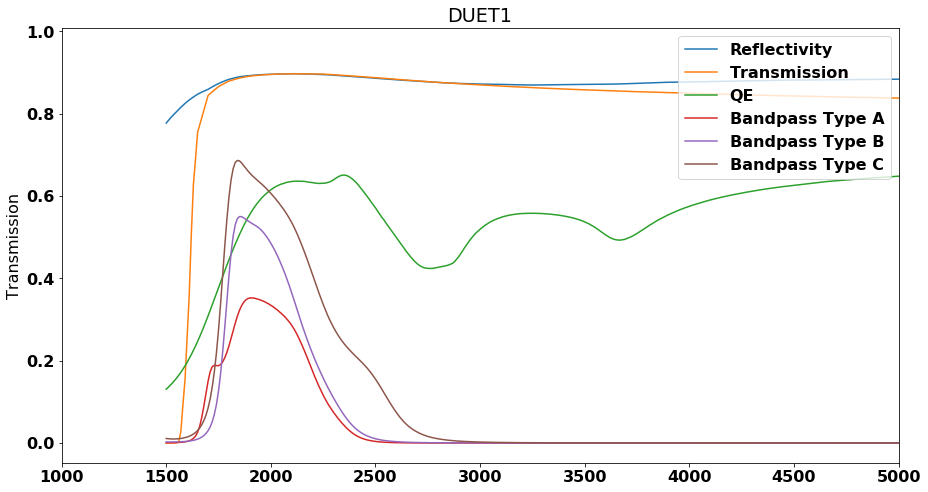

In [45]:
# Band 1

band_flux = duet.apply_filters(zodi['wavelength'], zodi['flux'], band=1, diag=True)

low_wave = duet.bandpass1[0]
high_wave = duet.bandpass1[1]

print(duet.qe_files['names'])
qe_wave, qe = load_qe(duet.qe_files['names'][0])

fig = plt.figure(figsize = (15, 8))
ax = fig.subplots()

ax.plot(ref_wave.to(u.AA), reflectivity, label='Reflectivity')
ax.plot(trans_wave.to(u.AA), transmission, label='Transmission')
ax.plot(qe_wave.to(u.AA), qe, label="QE")



for filter_type in ['A', 'B', 'C']:
    red_wave, red_trans = load_redfilter(duet.bandpass_files['names'][0], filter_type=filter_type)
    ax.plot(red_wave.to(u.AA), red_trans, label='Bandpass Type {}'.format(filter_type))
    
    

ax.set_ylabel('Transmission')
ax.set_xlim([1000, 5000])
ax.legend(loc=1)
ax.set_title('DUET1')
o2_total = duet.apply_filters(zodi['wavelength'], airglow_lines)
print(o2_total.sum() / airglow_lines.sum())



0.00024271246333372454


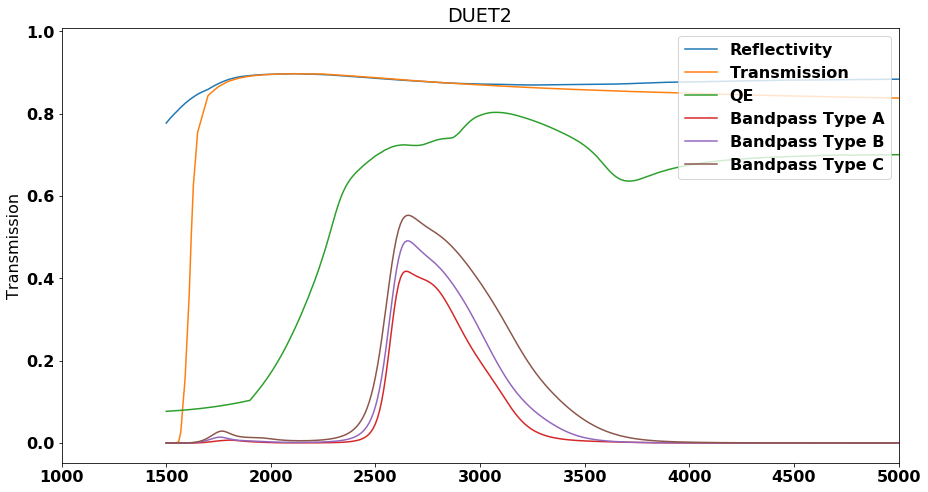

In [46]:
# Band 2
low_wave = duet.bandpass2[0]
high_wave = duet.bandpass2[1]

qe_wave, qe = load_qe(infile=duet.qe_files['names'][1], diag=True)

fig = plt.figure(figsize = (15, 8))
ax = fig.subplots()

ax.plot(ref_wave.to(u.AA), reflectivity, label='Reflectivity')
ax.plot(trans_wave.to(u.AA), transmission, label='Transmission')
ax.plot(qe_wave.to(u.AA), qe, label="QE")



for filter_type in ['A', 'B', 'C']:
    red_wave, red_trans = load_redfilter(duet.bandpass_files['names'][1], filter_type=filter_type)
    ax.plot(red_wave.to(u.AA), red_trans, label='Bandpass Type {}'.format(filter_type))
    
    o2_trans = apply_trans(zodi['wavelength'], airglow_lines, red_wave, red_trans)
ax.set_ylabel('Transmission')
ax.set_xlim([1000, 5000])
ax.legend(loc=1)
ax.set_title('DUET2')




o2_total = duet.apply_filters(zodi['wavelength'], airglow_lines, band=2)
print(o2_total.sum() / airglow_lines.sum())


----
1 C 0.8481874956457325 ph / s 0.33006711316178855 ph / s 0.0115 ph / s 0.08181427911701106
1 B 0.5039251602347222 ph / s 0.03122542778000025 ph / s 0.0115 ph / s 0.007043514629017045
1 A 0.36175910380082765 ph / s 0.014052092930311753 ph / s 0.0115 ph / s 0.0029359494416011894
----
2 C 1.0433255491273528 ph / s 0.46532375407986626 ph / s 0.0115 ph / s 0.054639113669841054
2 B 0.7446206836680562 ph / s 0.25550933908867535 ph / s 0.0115 ph / s 0.027165362035402433
2 A 0.5694747640928353 ph / s 0.1504191555205769 ph / s 0.0115 ph / s 0.012270299595529863


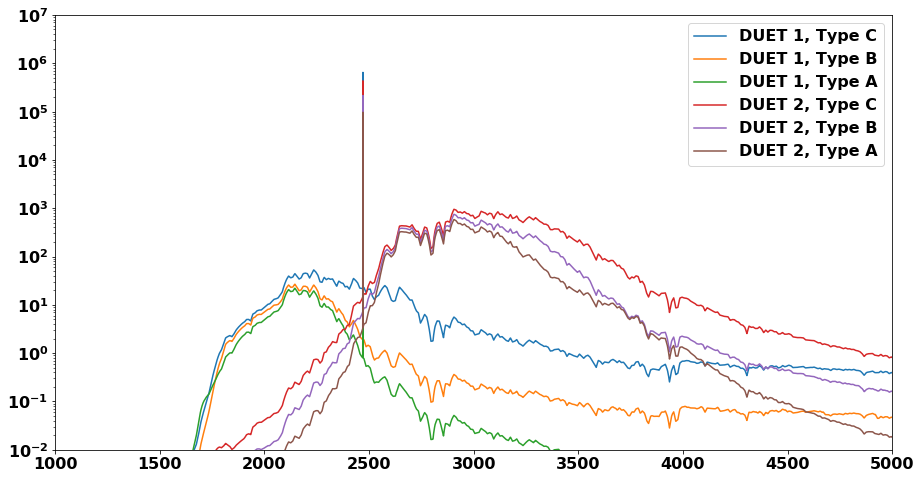

In [49]:
fig = plt.figure(figsize = (15, 8))
ax = fig.subplots()

for band in [1, 2]:
    print('----')
    for filter_type in ['C', 'B', 'A']:
        band_flux = duet.apply_filters(zodi['wavelength'], zodi['flux'], band=band, filter_type=filter_type)
        ax.plot(zodi['wavelength'], band_flux, label = 'DUET {}, Type {}'.format(band, filter_type))
        with_airglow = band_flux.sum()
        
        band_flux2 = duet.apply_filters(zodi['wavelength'], no_airglow, band=band, filter_type=filter_type)
        no_airglow_tot = band_flux2.sum()

        de = zodi['wavelength'][1] - zodi['wavelength'][0]
        ph_flux = (de*band_flux).to(u.ph / ((u.cm**2 * u.arcsec**2 * u.s)))
        
        o2_rate = duet.fluence_to_rate(ph_flux.sum()*pixel_area)
        
        airglow_obs = duet.apply_filters(zodi['wavelength'], airglow_lines, filter_type = filter_type, band=band)
        inrange = np.where(zodi['wavelength'] > 2000*u.AA)
        o2_supression = airglow_obs[inrange].sum() / airglow_lines[inrange].sum()
        
        fluence1, fluence2 = bb_abmag_fluence(duet = duet, filter_type = filter_type, bbtemp=15e3*u.K, swiftmag=21*u.ABmag)
        if band == 1:
            src_rate = duet.fluence_to_rate(fluence1)
        else:
            src_rate = duet.fluence_to_rate(fluence2)
        
        print(band, filter_type, src_rate, o2_rate,duet.dark_current,o2_supression)
    
    
ax.set_xlim([1000, 5000])
ax.set_ylim([1e-2, 1e7])
ax.set_yscale('Log')
ax.legend()
plt.show()